In [82]:
%matplotlib notebook
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import matplotlib
# from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from rasterio import features
from Map_Tools import map_elements as me
# from matplotlib.patches import BoxStyle

import geopandas as gpd
from matplotlib import colors
# import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.gridspec import GridSpec

G_Drive = 'C:\\Users\\User\\Google Drive\\'

Save_Plots=G_Drive+'PhD_Thesis\\Chapter3_Figs/'


Projected_Image = 'temp/FI_Projected.tif'


uint8
255


<IPython.core.display.Javascript object>


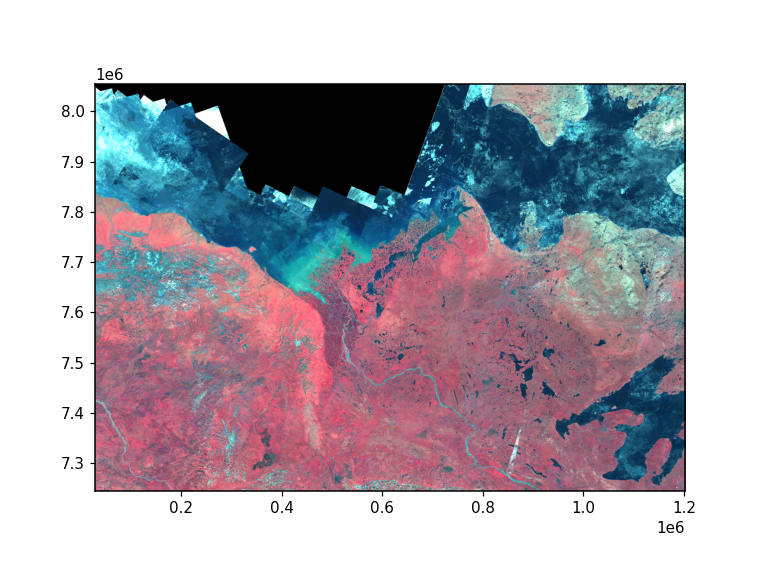

[[[0.         0.         0.         ... 0.46341464 0.597561   0.5731707 ]
  [0.         0.         0.         ... 0.47560975 0.34146342 0.41463414]
  [0.         0.         0.         ... 0.4512195  0.17073171 0.24390244]
  ...
  [0.41463414 0.47560975 0.9512195  ... 0.5365854  0.5365854  0.5487805 ]
  [0.69512194 0.81707317 1.         ... 0.5487805  0.58536583 0.5487805 ]
  [1.         1.         0.91463417 ... 0.5731707  0.597561   0.6097561 ]]

 [[0.         0.         0.         ... 0.6923077  0.7948718  0.71794873]
  [0.         0.         0.         ... 0.71794873 0.53846157 0.64102566]
  [0.         0.         0.         ... 0.71794873 0.41025642 0.41025642]
  ...
  [0.3846154  0.4871795  0.7692308  ... 0.46153846 0.43589744 0.43589744]
  [0.4871795  0.5897436  0.6923077  ... 0.41025642 0.3846154  0.3846154 ]
  [0.64102566 0.41025642 0.46153846 ... 0.41025642 0.3846154  0.41025642]]

 [[0.         0.         0.         ... 0.6666667  0.71428573 0.64285713]
  [0.         0.      

In [71]:
def pct_clip(array,pct=[2,98]):
    array_min, array_max = np.nanpercentile(array,pct[0]), np.nanpercentile(array,pct[1])
    clip = (array - array_min) / (array_max - array_min)
    clip[clip>1]=1
    clip[clip<0]=0
    return clip

with rio.open(G_Drive+'earthengine/False_Color_Landsat.tif') as src:
#     print(src.dtypes[0])
    print(src.dtypes[0])
    print(src.read(4).max())
    with rio.open(
            'temp/False_Color_Temp.tif', 'w+',
            driver='GTiff',
            dtype= rio.float32,
            count=3,
            crs = src.crs,
            width=src.width,
            height=src.height,
            transform=src.transform,
        ) as dst:
#         print(src.read(5))
        V = pct_clip(src.read(4+1))
        dst.write(V,1)
        V = pct_clip(src.read(3+1))
        dst.write(V,2)
        V = pct_clip(src.read(2+1))
        dst.write(V,3)
    
fig,ax=plt.subplots()
with rio.open("temp/False_Color_Temp.tif") as src2:
    print(src2.read())
    show(src2.read(),transform=src2.transform,ax=ax)

In [99]:
with rio.open(Projected_Image) as src:
    Im = src.read()
    params = src.profile
    Transform = src.transform
    NDVI = Im.max(axis=0)
    Mask = NDVI.copy()
    Mask[Mask<0.3]=0
    Mask[Mask>=0.3]=1
    
    Mask2= Mask.copy()
    Mask2[Mask2==0]=np.nan
    
    results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            features.shapes(Mask, mask=None, transform=src.transform)))
    
    
geoms = list(results)
Temp = gpd.GeoDataFrame.from_features(geoms)
Water = Temp.loc[Temp['raster_val']<1].copy()#
Water.loc[((Water['raster_val']>0.5)&(Water.area<1e6)),'raster_val']=np.nan
Bad = Water[Water.geometry.is_valid==False].buffer(0)
Water.loc[Water.geometry.is_valid==False,'geometry']=Bad.geometry
Water = Water.dropna().dissolve()

# fig,ax=plt.subplots()
# Water.plot(ax=ax)



In [100]:
FI_Poly= gpd.read_file(G_Drive+'SiteInfo\\FishIsland_Poly.shp')
BL_Poly= gpd.read_file(G_Drive+'SiteInfo\\BigLake.shp')
BLDP = BL_Poly.dissolve()

BLDP['Id']+=1
import pprint

shapes = ((geom,value) for geom,value in zip (BLDP['geometry'],BLDP['Id']))
# print(Polys.groupby('Code').sum().area)
with rio.open('temp/BLDP.tif','w+',**params) as out:
    out_arr=out.read(1)
    Image=features.rasterize(shapes=shapes,fill=-9999,out=out_arr,transform=Transform)
    Image = (Image+1) * Mask
    out.write(Image,1)
    results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            features.shapes(Image, mask=None, transform=src.transform)))

Filter = 1e5
    
geoms = list(results)
Temp = gpd.GeoDataFrame.from_features(geoms)
BLDP_Inv = Temp.loc[Temp['raster_val']>0].copy()#
BLDP_Inv.loc[((BLDP_Inv['raster_val']>0.5)&(BLDP_Inv.area<Filter)),'raster_val']=np.nan
BLDP_Inv.loc[((BLDP_Inv['raster_val']>1)),'raster_val']=np.nan
Bad = BLDP_Inv[BLDP_Inv.geometry.is_valid==False].buffer(0)
BLDP_Inv.loc[BLDP_Inv.geometry.is_valid==False,'geometry']=Bad.geometry
BLDP_Inv = BLDP_Inv.dropna().dissolve(by='raster_val')


BLDP = Temp.loc[Temp['raster_val']>1].copy()#
BLDP.loc[((BLDP['raster_val']>1)&(BLDP.area<Filter)),'raster_val']=np.nan
# BLDP_Inv.loc[((BLDP_Inv['raster_val']>1)),'raster_val']=np.nan
Bad = BLDP[BLDP.geometry.is_valid==False].buffer(0)
BLDP.loc[BLDP.geometry.is_valid==False,'geometry']=Bad.geometry
BLDP = BLDP.dropna().dissolve(by='raster_val')

In [101]:


rivers = gpd.read_file(G_Drive+'NorthernCan\\shapefiles\\LCC_NAD83/hydro_rivers_l.shp')
rivers = rivers.to_crs(FI_Poly.crs)
rivers = rivers.buffer(1e2)


land = gpd.read_file(G_Drive+'NorthernCan\\shapefiles\\LCC_NAD83/hydro_land_p.shp')
land = land.to_crs(FI_Poly.crs)
land = land.loc[land['FEAT_E']=='land']

# land.FEAT_E.unique()

<IPython.core.display.Javascript object>


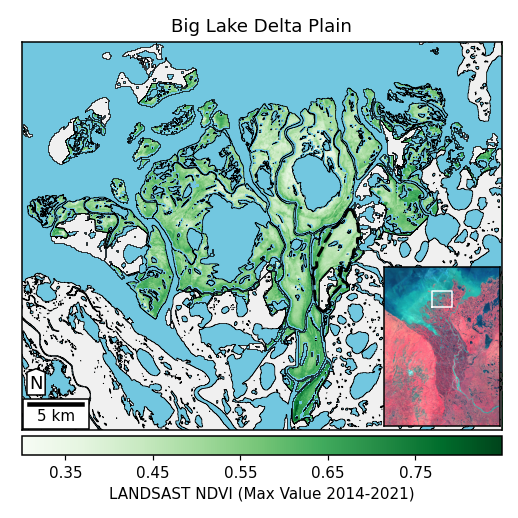

In [105]:
import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 1 #set the value globally

fig,ax = plt.subplots(figsize=(4.75,4.75))

CL = ['#d9fffe','#edf8e9','#bae4b3','#74c476','#31a354','#006d2c']
cmap = colors.ListedColormap(CL)
bounds = [-1,0.3,0.4,0.5,0.6,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

retted=show(Im.max(axis=0)*Mask2,ax=ax,cmap='Greens',
#retted=show(Im.max(axis=0),ax=ax,cmap=cmap,norm=norm,
            transform=Transform)
im = retted.get_images()[0]
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax,
                    ticks=[0.35,0.45,0.55,.65,0.75],
                    orientation='horizontal',label='LANDSAST NDVI (Max Value 2014-2021)')
# cbar.ax.set_xticklabels(['<0.3', '0.3 - < 0.4', '0.4 - < 0.5', '0.5 - < 0.6', r'$\geq$ 0.6'])  # horizontal colorbar

buff=5e2
xb = [BLDP.bounds['minx'].values[0]-buff,BLDP.bounds['maxx'].values[0]+buff]
yb = [BLDP.bounds['miny'].values[0]-buff,BLDP.bounds['maxy'].values[0]+buff]
ax.set_xlim(xb)
ax.set_ylim(yb)
# ax.set_ylim()

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Big Lake Delta Plain')

BLDP_Inv.plot(ax=ax,color='#f0f0f0',edgecolor='k',linewidth=.5)#,hatch="/")

BLDP.plot(ax=ax,color='None',edgecolor='k',linewidth=.5)#,hatch="/")

kwargs = {'facecolor':'#f0f0f0',
                 'edgecolor':'k',
                 'linewidth':0.15,
#                  'label':l
         }
axins = ax.inset_axes([0.7, 0.01, 0.35, 0.41])
# land.plot(ax=axins,**kwargs)


with rio.open('temp/False_Color_Temp.tif') as src2:
    FC = src2.read()
    show(FC,ax=axins,transform=src2.transform)

x_scale=1e5
y_scale2=5e4
y_scale1=2.5e5


xbins = [xb[0]-x_scale,xb[1]+x_scale]
ybins = [yb[0]-y_scale1,yb[1]+y_scale2]
axins.set_xlim(xbins)
axins.set_ylim(ybins)


XB = [xb[0],xb[0],xb[1],xb[1],xb[0]]
YB = [yb[0],yb[1],yb[1],yb[0],yb[0]]

ax.set_facecolor('#72c7e0')
# axins.set_facecolor('#72c7e0')

# import matplotlib.patheffects as pe

# rivers.plot(ax=axins,facecolor='#72c7e0',edgecolor='k',linewidth=0.25)#,foreground='g')#path_effects=[pe.Stroke(linewidth=5, foreground='g')])
axins.plot(XB,YB,color='white',linewidth=1)

axins.get_xaxis().set_visible(False)
axins.get_yaxis().set_visible(False)


me.scalebar(ax,distance=5e3,label='5 km')

me.North_Arrow(ax,x=0.03,y=0.12)


FI_Style = {'facecolor':'None',
            'edgecolor':'k',
            'linestyle':'--',
            'linewidth':2}

FI_Poly.plot(ax=ax,**FI_Style)

plt.tight_layout()
plt.savefig(Save_Plots+'Greenest_Pixel.png',dpi=600)


In [88]:
# with rio.open('temp/False_Color_Temp.tif') as src:
#     FC = src.read()#[2,3,4])
#     params = src.profile
#     Transform = src.transform
#     plt.figure()
#     show(FC)